# Project Part 2: Traning The Song Popularity Score Prediction Model

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/cdinh92/CS39AA-project/blob/main/project_part2.ipynb)

Welcome to the data science project undertaken for the CS39AA NLP Machine Learning class at MSU Denver. In this exploration, the aim is to delve into the world of music industry and investigate whether a predictive model can be designed to forecast the success of songs based on the popularity scores. The focus of this analysis lies on 8 key song features: danceability, energy, mode, loudness, speechiness, instrumentalness, tempo, and valence.

**Check the Project Part 1 [here](https://github.com/cdinh92/CS39AA-Project/blob/main/project_part1.ipynb)**

## 1. Introduction

After exploring the Spotify top songs dataset by Joakim Arvidsson on [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs), I reduce it to nearly 15000 songs in the clean file named [filtered_spotify_songs.csv](https://github.com/cdinh92/CS39AA-Project/blob/main/filtered_spotify_songs.csv). Now, as we step into the training phase, three formidable models — **Random Forest**, **Decision Tree**, and **Linear Regression** — take center stage for a comparative analysis

**Initial Prediction:**
Early predictions lean towards **Random Forest** outperforming, especially on large datasets typical of regression problems. However, this model pose a major challenge that it can’t extrapolate outside unseen data. We’ll dive deeper into these challenge later.

**Alternative Approach:**
While recognizing the potential limitations of predictive models in capturing the entirety of a song's success factors, this project might also seeks to identify common features among trending songs, just in case the predictive results are far from expectations.

## 2. Training the predicting models

Let's explore the dataset and drop some columns

In [13]:
# import all of the python modules/packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

def RMSE(y,yhat):
    return np.sqrt(mean_squared_error(y,yhat))

# Check the filtered spotify songs csv file
# This block is for both local work and Github repository execute
try:
    raw_data = pd.read_csv("filtered_spotify_songs.csv")
    print("CSV file found and loaded.")
except FileNotFoundError:
    raw_data = pd.read_csv("https://raw.githubusercontent.com/cdinh92/CS39AA-Project/main/filtered_spotify_songs.csv")

# Specify the columns to keep for the training part
columns_to_keep = ['track_popularity','danceability','energy','speechiness','loudness','mode','instrumentalness','valence','tempo']

# Use loc to select only the specified columns
data = raw_data.loc[:, columns_to_keep]
data.info()

CSV file found and loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14925 entries, 0 to 14924
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_popularity  14925 non-null  int64  
 1   danceability      14925 non-null  float64
 2   energy            14925 non-null  float64
 3   speechiness       14925 non-null  float64
 4   loudness          14925 non-null  float64
 5   mode              14925 non-null  int64  
 6   instrumentalness  14925 non-null  float64
 7   valence           14925 non-null  float64
 8   tempo             14925 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.0 MB


The dataset looks good. Let's jump to the fitting model part

#### 1. Fitting the models
In this part we will fit three different models: Decision Tree, Random Forest, and Linear Regression for the dataset

In [14]:
# Create target object and call it y
Y = data.track_popularity
# Create X
features = ['danceability','energy','speechiness','loudness','mode','instrumentalness','valence','tempo']
X = data[features]

scaler = RobustScaler()
data = scaler.fit_transform(data.astype(np.float64))
data = scaler.fit_transform(data.astype(np.int64))

#Split into validation and training data
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state= 42)

# Fit Decision Tree Model
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)

# Fit Random Rorest Model
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)

# Fit Linear Regression Model
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(x_train, y_train)



LinearRegression(n_jobs=-1)

#### 2. Compare the models

In [17]:
# Using The Root Mean Squared Error (RMSE)
models= [('Linear Regression Model:', lin_reg), ('Random Forest Model: ', forest), ('Decision Tree Model', tree)]
for i, model in models:    
    predictions = model.predict(x_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of Linear Regression Model: = 20.78
RMSE of Random Forest Model:  = 8.24
RMSE of Decision Tree Model = 3.02


**Comments:** A higher RMSE value indicates that, on average, your model's predictions have larger errors compared to the actual values. Random Forest and Decision Tree Model give better predictive performance as they have lower RMSE values indicating smaller magnitude of errors in the model's predictions.

In [22]:
# Using the Score ()
print(lin_reg.score(x_train,y_train))
print(forest.score(x_train,y_train))
print(tree.score(x_train,y_train))

0.06645154240111695
0.853301109435769
0.9802629622561101


**Comments:** Random Forest and Decision Tree Model give better predictive performance. I was surprised that Decision Tree Model outperforms the others with 98% on the training dataset

In [23]:
# Test three different scoring metrics for each model
models= [('Linear Regression Model:', lin_reg), ('Random Forest Model: ', forest), ('Decision Tree Model', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

results= []
metric= []

for name, model in models:
    for i in scoring:
        scores = cross_validate(model, x_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [27]:
""" 
These codes get from Random Forest hyperparameters tuning 
at https://www.kaggle.com/code/emanueleamcappella/random-forest-hyperparameters-tuning
for comparing different model performances
"""
# This is for Linear Regression
# If you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# Note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

# This is for Random Forest
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

# This is for Decision Tree
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
0,Linear Regression,20.800113,12.190990,16.769144,0.296540,0.064752,0.014759
1,Random Forest,21.115909,13.980115,16.719862,0.328865,0.037832,0.025046
2,Decision Trees,29.384782,20.685501,23.116396,0.491166,-0.852799,0.054882


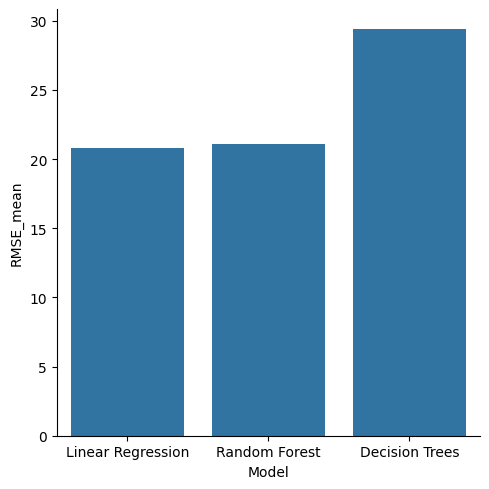

In [29]:
# Graph RMSE_mean for three models
sns.catplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend=True)

**Comments:** Now decision trees are not so good in comparison with the other two methods, both in terms of error and variance explained. The best model overall is Random Forest. Let's come to the Tuning Randome Forest Model Part
#### 3. Tuning Model: Random Forest using GridSearchCV
Pass RandomFoestRegressor() instance to the model and then Fit the GridSearchCV using the Training data to find the best parameters.

In [30]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [77]:
grid_search = GridSearchCV(RandomForestRegressor(), 
                           param_grid=param_grid) 
grid_search.fit(x_train, y_train) 
print(grid_search.best_estimator_) 

RandomForestRegressor(max_depth=6, max_features=None, max_leaf_nodes=9,
                      n_estimators=150)


Now we will update the parameters of the model by those which are obtained by using GridSearchCV.

In [ ]:
model_grid = RandomForestRegressor(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=150) 
model_grid.fit(x_train, y_train) 
y_pred_grid = model_grid.predict(x_test) 
accuracy = accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy:.2f}')
conf_matrix = confusion_matrix(y_test, y_pred_grid)
print('Confusion Matrix:')
print(conf_matrix)
class_report = classification_report(y_test, y_pred_grid)
print('Classification Report:')
print(class_report)